In [2]:

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.cm as cm
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import make_scorer,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

    
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

%matplotlib inline

In [3]:
cwd = os.getcwd()
data_wd = cwd + '/data/la-haute-borne-data-2013-2016.csv'
data = pd.read_csv(data_wd,sep=';')

In [4]:
data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80711,2013-01-07T01:20:00+01:00,41.160000,-1.000000,44.990002,11.27,12.65,12.0,13.0,0.41,...,NaN,NaN,37.77000,NaN,NaN,NaN,33.75000,NaN,NaN,NaN
1,R80711,2013-01-05T22:20:00+01:00,-1.000000,-1.000000,-0.870000,0.01,12.95,12.0,13.0,0.16,...,NaN,NaN,313.35001,NaN,NaN,NaN,279.92999,NaN,NaN,NaN
2,R80711,2013-01-06T08:30:00+01:00,-1.000000,-1.000000,-1.000000,0.00,13.74,13.0,14.0,0.35,...,NaN,NaN,241.59000,NaN,NaN,NaN,246.67999,NaN,NaN,NaN
3,R80711,2013-01-05T21:10:00+01:00,44.990002,44.990002,44.990002,0.00,12.14,12.0,13.0,0.27,...,NaN,NaN,280.75000,NaN,NaN,NaN,274.12000,NaN,NaN,NaN
4,R80711,2013-01-06T11:20:00+01:00,-0.760000,-1.000000,0.000000,0.40,13.78,13.0,14.0,0.35,...,NaN,NaN,293.01001,NaN,NaN,NaN,293.87000,NaN,NaN,NaN


In [5]:
data.sort_values(by=['Date_time'], inplace=True, ascending=True)

data['Date_time'] = pd.to_datetime(data['Date_time'], errors='coerce', utc=True)
data['Year'] = data['Date_time'].dt.year
data['Month'] = data['Date_time'].dt.month

data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std,Year,Month
321617,R80721,2012-12-31 23:00:00+00:00,-1.01,-1.04,-1.00,0.01,15.87,15.00,16.0,0.26,...,184.16000,NaN,NaN,NaN,186.10001,NaN,NaN,NaN,2012,12
685016,R80736,2012-12-31 23:00:00+00:00,-1.00,-1.00,-0.76,0.01,14.97,14.05,15.0,0.12,...,184.19000,NaN,NaN,NaN,184.00000,NaN,NaN,NaN,2012,12
524480,R80711,2012-12-31 23:00:00+00:00,-1.00,-1.00,-1.00,0.00,12.76,12.00,13.0,0.36,...,180.25000,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
828792,R80790,2012-12-31 23:00:00+00:00,-0.98,-0.99,-0.97,0.01,15.00,15.00,15.0,0.00,...,184.05000,NaN,NaN,NaN,184.59000,NaN,NaN,NaN,2012,12
216394,R80711,2012-12-31 23:10:00+00:00,-1.00,-1.00,-1.00,0.00,12.71,12.00,13.0,0.38,...,183.28999,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12


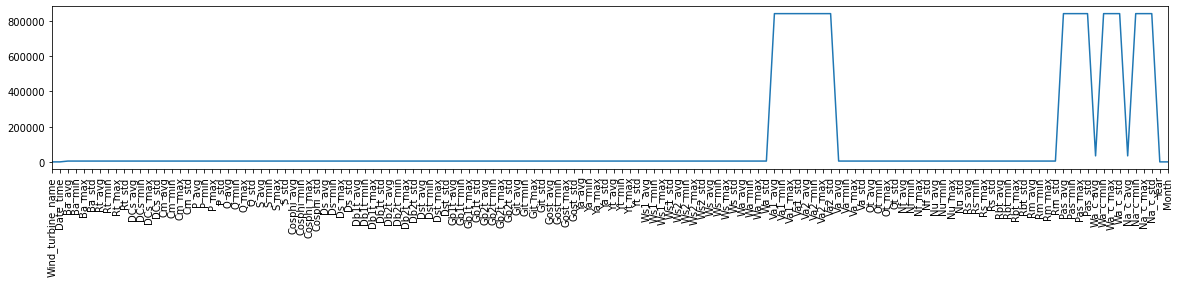

In [6]:
plt.figure(figsize=(20,3))
plt.plot(data.isnull().sum(axis = 0))
plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()

In [7]:
print('List of columns deleted because of NaN count exceeds maximum threshold')
print(list(data.loc[:,data.isnull().sum(axis = 0) > 10000].columns))
df = data.loc[:,data.isnull().sum(axis = 0) < 10000]

List of columns deleted because of NaN count exceeds maximum threshold
['Va1_avg', 'Va1_min', 'Va1_max', 'Va1_std', 'Va2_avg', 'Va2_min', 'Va2_max', 'Va2_std', 'Pas_avg', 'Pas_min', 'Pas_max', 'Pas_std', 'Wa_c_avg', 'Wa_c_min', 'Wa_c_max', 'Wa_c_std', 'Na_c_avg', 'Na_c_min', 'Na_c_max', 'Na_c_std']


In [8]:
df.head()


,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Year,Month
321617,R80721,2012-12-31 23:00:00+00:00,-1.01,-1.04,-1.00,0.01,15.87,15.00,16.0,0.26,...,25.889999,25.700001,26.000000,0.04,3759.9700,2334.3799,7177.3599,801.66998,2012,12
685016,R80736,2012-12-31 23:00:00+00:00,-1.00,-1.00,-0.76,0.01,14.97,14.05,15.0,0.12,...,26.049999,26.000000,26.100000,0.04,4298.0498,3287.3999,7509.1699,837.07001,2012,12
524480,R80711,2012-12-31 23:00:00+00:00,-1.00,-1.00,-1.00,0.00,12.76,12.00,13.0,0.36,...,28.709999,28.600000,28.799999,0.03,5690.2798,4037.4900,7382.7202,612.64001,2012,12
828792,R80790,2012-12-31 23:00:00+00:00,-0.98,-0.99,-0.97,0.01,15.00,15.00,15.0,0.00,...,32.930000,32.700001,33.099998,0.11,5791.4502,4104.9600,7362.1802,662.44000,2012,12
216394,R80711,2012-12-31 23:10:00+00:00,-1.00,-1.00,-1.00,0.00,12.71,12.00,13.0,0.38,...,28.700001,28.600000,28.750000,0.01,5632.7202,3579.1001,7386.1099,746.62000,2012,12


In [9]:
df.shape[0]


840380

In [10]:
df_no_na = df.dropna()
df_no_na.shape[0]

835702

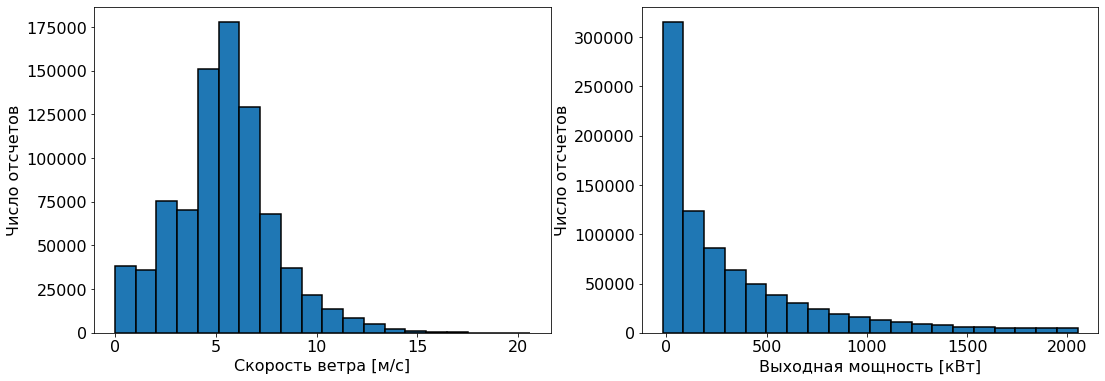

In [11]:
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(18,6))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(df_no_na['Ws_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
# ax1.set_title('Распределение скорости ветра 2013-2016')
ax1.set_xlabel('Скорость ветра [м/с]')
ax1.set_ylabel('Число отсчетов')
ax2.hist(df_no_na['P_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
# ax2.set_title('Распределение выходной мощности 2013-2016')
ax2.set_xlabel('Выходная мощность [кВт]')
ax2.set_ylabel('Число отсчетов')

plt.show()

In [12]:
df_clean = df_no_na[df_no_na['Ws_avg']>3]
df_clean = df_clean[df_clean['Ws_avg'] < 25]
df_clean = df_clean[df_clean['Ba_avg'] < 5]
df_clean = df_clean[df_clean['Ba_avg'] > -5]
df_clean.shape[0]

617315

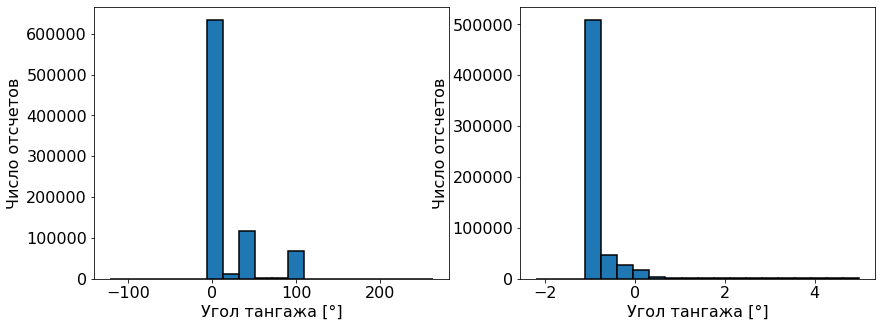

In [13]:
f = plt.figure(figsize=(14,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(df_no_na['Ba_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
# ax1.set_title('Распределение угла тангажа перед фильтрацией данных')
ax1.set_xlabel('Угол тангажа [°]')
ax1.set_ylabel('Число отсчетов')
ax2.hist(df_clean['Ba_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
# ax2.set_title('Распределение угла тангажа после фильтрации данных')
ax2.set_xlabel('Угол тангажа [°]')
ax2.set_ylabel('Число отсчетов')

plt.show()

In [14]:
df_clean['E_avg'] = df_clean['P_avg'] / 6000 # from kW to MWh
df_energy = pd.DataFrame(df_clean.groupby(['Year', 'Month'])['E_avg'].apply(lambda x : x.sum()))
df_energy.reset_index(inplace=True)

In [15]:
df_energy_boxplot = df_energy[df_energy.E_avg > 10]



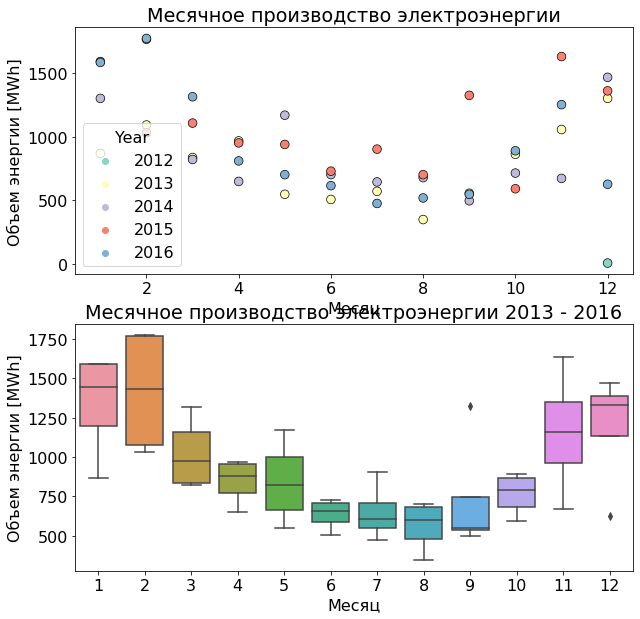

In [16]:
f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

sns.scatterplot(x="Month", y="E_avg", hue = 'Year', data=df_energy, s = 75, ax = ax1, palette = "Set3", edgecolor = 'black',legend='full')
ax1.set_title('Месячное производство электроэнергии')
ax1.set_xlabel('Месяц')
ax1.set_ylabel('Объем энергии [MWh]')

sns.boxplot(x="Month", y="E_avg", data=df_energy_boxplot, ax = ax2)
ax2.set_title('Месячное производство электроэнергии 2013 - 2016')
ax2.set_xlabel('Месяц')
ax2.set_ylabel('Объем энергии [MWh]')

plt.close(2)

In [17]:
P_nom = 2050 # kW | nominal power
df_clean['Cf_avg'] = df_clean['P_avg'] / P_nom # from kW to CF
df_cf = pd.DataFrame(df_clean.groupby(['Year', 'Month'])['Cf_avg'].apply(lambda x : x.mean()))
df_cf.reset_index(inplace=True)

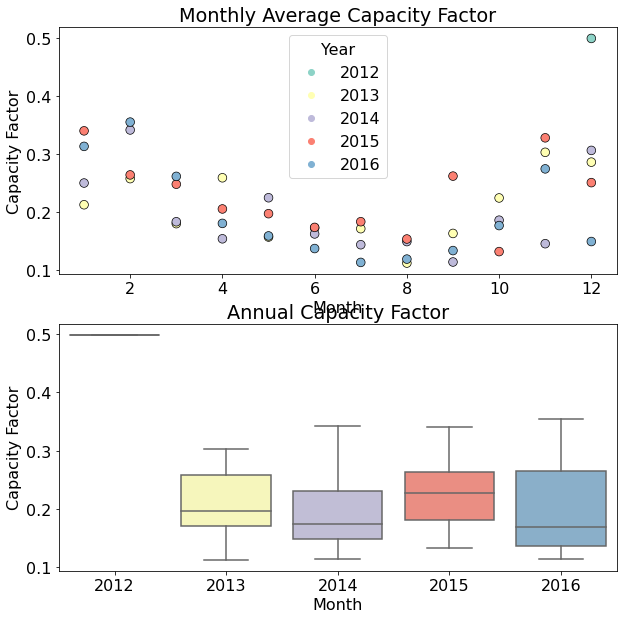

In [18]:

df_cf_boxplot = df_cf[(df_cf.Cf_avg > 0.05) & (df_cf.Cf_avg < 0.5)]

f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

sns.scatterplot(x="Month", y="Cf_avg", hue = 'Year', data=df_cf_boxplot, s = 75, ax = ax1, palette = "Set3", edgecolor = 'black')
ax1.set_title('Monthly Average Capacity Factor')
ax1.set_xlabel('Month')
ax1.set_ylabel('Capacity Factor')

sns.boxplot(x="Year", y="Cf_avg", data=df_cf_boxplot, ax = ax2, palette = "Set3")
ax2.set_title('Annual Capacity Factor')
ax2.set_xlabel('Month')
ax2.set_ylabel('Capacity Factor')

plt.close(2)

In [19]:
def CatVarManagement(df,col_name):
    df_dummy = pd.get_dummies(df[col_name],prefix='M')
    df_new = pd.concat([df, df_dummy], axis=1)
    df_new = df_new.drop(col_name, axis = 1)
    return df_new

In [20]:
def RFTraining(df_train,df_test):
    # target feature to be predicted (average power output)
    label = 'P_avg'
    # feature/label separation for train data (2013-2015)
    X_train = df_train.drop(label,axis=1)
    y_train = df_train.loc[:,label]
    # feature/label separation for train data (2016)
    X_test = df_test.drop(label,axis=1)
    y_test = df_test.loc[:,label]
    # model definition and training
    rfr = RandomForestRegressor(max_depth=15,n_estimators=30,verbose = 1, n_jobs=4)
    rfr.fit(X_train,y_train)
    # model prediction and performance metrics
    y_predict = rfr.predict(X_test)
    print_msg = 'Model Performance Metrics: \n MAE: {0} \n MSE: {1}'
    print(print_msg.format(mean_absolute_error(y_test,y_predict),mean_squared_error(y_test,y_predict))) 
    df_solutions = pd.DataFrame({'true' : np.array(y_test), 'predicted' : np.array(y_predict)})
    return rfr,df_solutions

In [21]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

def RFT_tuning(model, df_train, df_test):
    # target feature to be predicted (average power output)
    label = 'P_avg'
    # feature/label separation for train data (2013-2015)
    X_train = df_train.drop(label,axis=1)
    y_train = df_train.loc[:,label]
    # feature/label separation for train data (2016)
    X_test = df_test.drop(label,axis=1)
    y_test = df_test.loc[:,label]
    
    search_space = {
        "max_depth": Integer(6, 20), # values of max_depth are integers from 6 to 20
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(12, 35)
    }
    
    def on_step(optim_result):
        """
        Callback meant to view scores after
        each iteration while performing Bayesian
        Optimization in Skopt"""
        score = forest_bayes_search.best_score_
        print("best score: %s" % score)
        if score >= 0.98:
            print('Interrupting!')
            return True
    
    forest_bayes_search = BayesSearchCV(model, search_space, n_iter=32, n_jobs=-1, cv=5)
    forest_bayes_search.fit(X_train, y_train, callback=on_step) # callback=on_step will print score after each iteration
    return forest_bayes_search

In [22]:
features = ['Ws1_avg', 'Ws1_min', 'Ws1_max', 'Ws1_std', 
            'Ws2_avg', 'Ws2_min', 'Ws2_max', 'Ws2_std', 
            'Wa_avg', 'Wa_min', 'Wa_max', 'Wa_std',
            'Ot_avg', 'Ot_min', 'Ot_max', 'Ot_std','Month','P_avg']
df_model = df_clean.copy()
df_train = df_model.loc[df_model['Year']!=2016,features]
df_test = df_model.loc[df_model['Year']==2016,features]
dt_test = pd.DataFrame(df_model.loc[df_model['Year']==2016,'Date_time'])

df_train = CatVarManagement(df_train,'Month')
df_test = CatVarManagement(df_test,'Month')

In [23]:
df_solutions = []
model, df_solutions = RFTraining(df_train,df_test)

df_solutions = pd.concat([df_solutions.reset_index(drop=True),
           pd.Series(df_clean.loc[df_clean['Year']==2016,'Date_time']).reset_index(drop=True)],axis=1)

tuned = RFT_tuning(model, df_train, df_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   32.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Model Performance Metrics: 
 MAE: 28.040827033110855 
 MSE: 1704.1852865781807


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.2s finished


best score: 0.9885081005164817
Interrupting!


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 out of  13 | elapsed:    3.0s finished


In [24]:
print(tuned.best_params_)
print(tuned.best_estimator_)
print(tuned.best_score_)

OrderedDict([('max_depth', 13), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 13)])
RandomForestRegressor(max_depth=13, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=13, n_jobs=4,
                      verbose=1)
0.9885081005164817


No handles with labels found to put in legend.


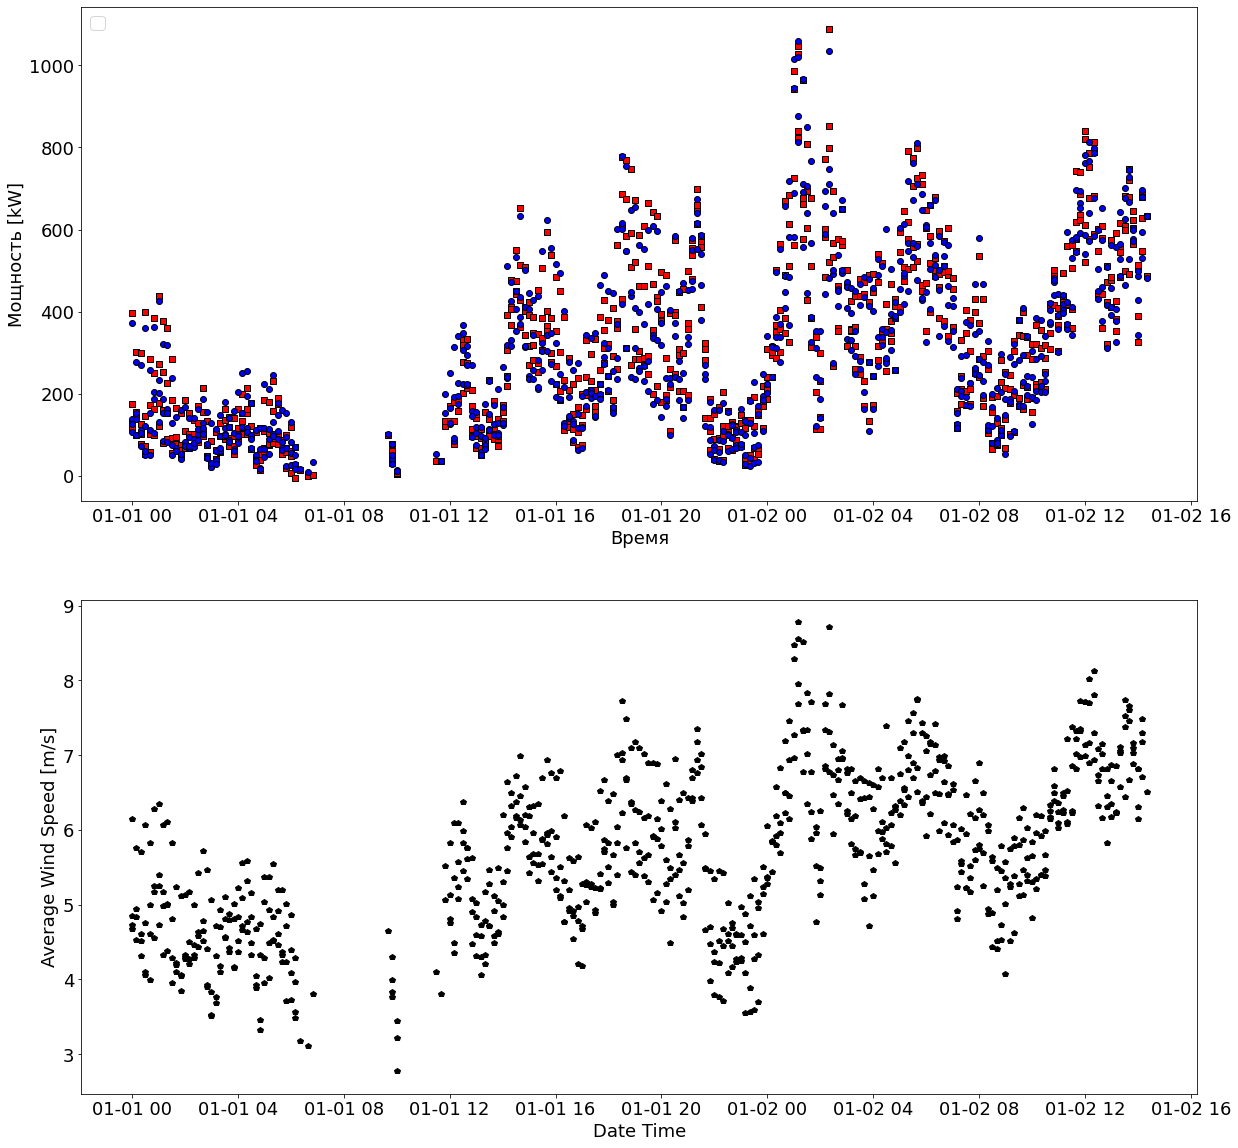

In [25]:
n = 800
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(211)
# ax1.set_title('Предсказанные и Реальные значения вырабатываемой мощности')
ax1.set_xlabel('Время')
ax1.set_ylabel('Мощность [kW]')
ax1 = plt.plot_date(df_solutions.loc[0:n,'Date_time'],df_solutions.loc[0:n,'true'],
                   markerfacecolor = 'red',markeredgecolor='black',marker='s')
ax1 = plt.plot_date(df_solutions.loc[0:n,'Date_time'],df_solutions.loc[0:n,'predicted'],
                   markerfacecolor = 'blue',markeredgecolor='black',marker='o')

plt.legend(loc='upper left')

ax2 = fig.add_subplot(212)
ax2.set_xlabel('Date Time')
ax2.set_ylabel('Average Wind Speed [m/s]')
ax2 = plt.plot_date(dt_test.Date_time[0:n],df_test.reset_index().loc[0:(n-1),'Ws1_avg'],
                   markerfacecolor = 'black',markeredgecolor='black',marker='p')

plt.show()

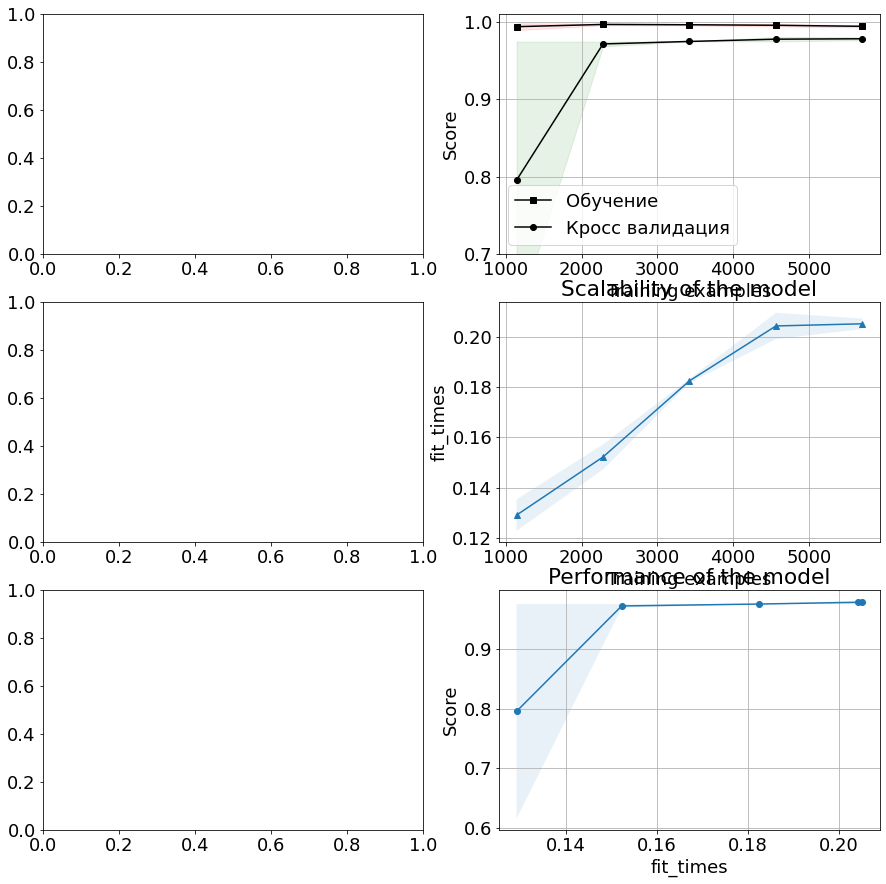

In [45]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 's-', color="black",
                 label="Обучение")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="black",
                 label="Кросс валидация")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, '^-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(15, 15))


# target feature to be predicted (average power output)
label = 'P_avg'
# feature/label separation for train data (2013-2015)
X_train = df_train.drop(label,axis=1)
y_train = df_train.loc[:,label]
# feature/label separation for train data (2016)
X_test = df_test.drop(label,axis=1)
y_test = df_test.loc[:,label]

estimator = RandomForestRegressor(max_depth=8, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=20, n_jobs=4, verbose=1)
plot_learning_curve(estimator, "", X_train, y_train, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=2, n_jobs=4, train_sizes=[0.005, 0.01, 0.015, 0.02, 0.025])

plt.show()